In [21]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# Maximum Likelihood Estimate - Example with a Normal Model

## Preamble
Maximum Likelihood Estimate (MLE) is the frequentist way of performing inference, and is different from a propability distribution in Bayesian inference. In this notebook, a paradigm is provided to show how MLE programmatically works.

## Introduction

Very often we need to estimate the parameters of a model given a set of observed data. 
Usually, we fix the model, for example a linear model or a normal distribution, and we use observed data set
$X = \{x_1,\, x_2,\, \ldots x_N\}$ with $N \in \mathbb{Z}^{>0}$ to extract the model's parameters, denoted as $\mathbf{\theta}$.

But how are the parameters actually being estimated?
For example, we can sample a random variable $x$ which we assume to obey to a normal distribution with a certain mean $\mu$ and variance $\sigma^2$. Then, our goal is to find estimations of the parameters $\mu$ and $\sigma^2$ from the given sata sample which accurately represent the true $x$, not solely the samples we have drawn out.

Consider we are performing a gaussian fit to our data, and our model estimates the coefficients for these data $X$
on the dependent variable $y$. How can we maximize the likelihood, i.e. the probability, that our estimator $\hat{\theta}$ is stemming from the true data $x$? And, once we have the sample value, how do we make sure that it is indeed correct?

## Parameters Estimation

Let's get started with the Probability Density function (PDF) for the Normal Distribution, 

\begin{equation}
\cal{L}(x;\, \mu,\, \sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2} \label{eq:gaus}
\end{equation}

and dive into some of the maths. The parameter $\mu$ is the mean or expectation of the distribution (and also its median and mode), while the parameter $\sigma$  is its standard deviation. The variance of the distribution is $\sigma^2$. A random variable with a Gaussian distribution is said to be normally distributed, and is called a normal deviate.

Equation $\eqref{eq:gaus}$ is telling us the likelihood $\cal{L}$ , i.e. the probability, for the random variable $x$ from our same, when the true parameters of the distribution are $\mu$ and $\sigma$.

In [3]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from scipy.stats import gaussian_kde

Let's assume, for example, our data sample is $x=1$, what is the probability it comes from a normal distribution characterized by $\mu=0$ and $\sigma=1$?

In [7]:
x=1
μ=0
σ=1
stats.norm.pdf(x, μ, σ)

0.24197072451914337

In [8]:
x=0
μ=0
σ=1
stats.norm.pdf(x, μ, σ)

0.3989422804014327

The PDF equation shows, therefore, how likely those data points is to appear in a given distribution with certain parameters. So, it is more likely it came from the second distribution.

Let’s assume now we get a bunch samples from $\{x\}$, which we a-priori know to come from some normal distribution. Also, we know that all data examples are mutually independent from each other. If this is the case, the total probability of observing all of the uncorrelated data is simply the product of obtaining each data point
individually:

\begin{equation}
p(x_{i:N};\, \mu,\, \sigma) = \prod_i^N p(x_i;\, \mu,\, \sigma)
\end{equation}

For example, we want to calculate the probability of $x =1,\, -2 $  are drawn from a distribution with $\mu=0$ and $\sigma=1$ we obtain:

In [9]:
stats.norm.pdf(1, 0, 1) * stats.norm.pdf(-2, 0, 1) 

0.013064233284684923

## Likelihood for data samples

Consider a random set of data $X = \{\ldots\}$ and different PDFs represented by a normal distributions $\sim N(\mu,\, \sigma)$. This particular sample could be theoretically drawn from any distribution with parameters $(\mu,\, \sigma)$. But which distributions is more likely to be the true data generator?

So, we want to estimate $p(X;\, \mu,\, \sigma)$; the probability these data points stemm from a normal distribution with $\theta=(\mu,\,\sigma)$. We can achieve this through maximimzing a likelihood fuction, a method which is also known as Maximum Likelihood Estimation (MLE). This will allow us to specify a distribution of
unknown parameters $\theta$, and then using the available data to pull out the actual values of those unknown parameters.

We now want to maximize the likelihood our parameter(s) $\theta$ coming from a specific PDF. A common technique to facilitate the process further, is to take the logarithm of the likelihood equation. When we take the $\log$ of the the PDF equation, then we deal with the "log likelihood" PDF, shown by the following equation 

\begin{equation}
\log {\cal{L}}(x_i;\, \mu,\,\sigma) = - \frac{N}{2}\log(2\pi) -N log(\sigma) - \frac{1}{2\sigma^2} \sum_i^N (x_i - \mu)^2
\label{eq:llh}
\end{equation}

To make things clear, let's define a set of data points for which we want to find a normal distribution that best describes those data.

In [11]:
X_data = [4,5,7,8,8,9,10,5,2,7,6,3,5,4,8,9,6]

Let's also define the parameter space in which we aim to search for that best PDF with the unknown parameters.

In [13]:
#mean
μ_range = np.arange(5.5, 6.5, 0.01).tolist()

#standard deviation
σ_range = np.arange(2, 3, 0.01).tolist()

During the scan in the $\theta=(\mu,\,\sigma)$ parameter space, we want to collect results of the minimum log-likehood for each of the proposed parameter sets. To keep things organized, we define a class which stores such kind of information. 

In [17]:
class NLLH:
    '''
    Class to store and process NLLH results
    obtained from a theta parameter space scan
    '''
    def __init__(self, nllh=None, μ=None, σ=None):
        self.__nllh = nllh
        self.__μ = μ
        self.__σ = σ
        self.__Σ_nllh = sum(nllh)
        self.__quality = self.__check()
        self.__n_points = len(nllh)
        self.__label = '$\mu$=%.2f $\sigma$=%.2f'%(μ, σ)
        self.__best = False
        self.__alpha = 0.2

    def __str__(self):
        return f'NLLH: {self.__Σ_nllh} μ: {self.__μ} σ: {self.__σ}'

    def __check(self):
        if math.isnan(self.__Σ_nllh) or math.isinf(self.__Σ_nllh):
            return False
        return True

    def ok(self):
        return self.__quality
    
    @property
    def nllh(self):
        return self.__nllh

    @property
    def μ(self):
        return self.__μ

    @property
    def σ(self):
        return self.__σ
    
    @property
    def Σ_nllh(self):
        return self.__Σ_nllh

    @property
    def n_points(self):
        return self.__n_points

    @property
    def label(self):
        return self.__label

    @property
    def best(self):
        return self.__best

    @best.setter
    def best(self, x):
        self.__best = x
        self.__label = self.__label.\
            replace('\mu', '\hat{\mu}').\
            replace('\sigma', '\hat{\sigma}')\
            + ' (best)'

    @property
    def alpha(self):
        return self.__alpha

Next, we define the parameter space on which we will iterate and estimate the Log-Likelihood for the given random data points we started with.

In [16]:
# parameter space
μ_range = np.arange(5.5, 6.5, 0.01).tolist()
σ_range = np.arange(2, 3, 0.01).tolist()

Now we are ready to perform a 2D iterative process over the $\theta=(\mu,\,\sigma)$. In each iteration, we store the result of the negative log-likelihood (NLLH). Since we decided to invert the sign of the LLH for practical reasons, we aim now to find the values of the unknown parameters $\theta$ that minimize this quantity.

In [19]:
#list keeping the NLLH of each set of parameters
nllh_results = []

#parameter scan and NLLH estimate
for μ, σ in itertools.product(μ_range, σ_range):
    #print(f'scanning {μ} {σ}')
    temp_nllh = []
    for x in X_data:
        pdf = stats.norm.pdf(x, μ, σ)
        if pdf > 0:
            temp_nllh.append(-np.log(pdf))

    #keep the NLLH for this μ, σ
    nllh_results.append( NLLH(nllh=temp_nllh, μ=μ, σ=σ) )

Sort the results obtained for each $\theta$ hypothesis by $-\log\mathcal{L}$.

In [20]:
#sort
nllh_results.sort(key=lambda x: x.Σ_nllh, reverse=False)

#the first result should be the minimum NLLH 
nllh_results[0].best = True

print('Scanned points', len(nllh_results))
print("Data size %i, NLLH size %i"%(len(X_data), nllh_results[0].n_points))
print('Best model from MLE', nllh_results[0])

Scanned points 10000
Data size 17, NLLH size 17
Best model from MLE NLLH: 37.605847832169104 μ: 6.239999999999984 σ: 2.2099999999999955


This is how the problem is approached numerically. But does, in addition, an analytical solution exit? The answer is 'yes'. In this case, we seek to maximize our equation with respect to each of our parameters and thus we need to take the first derivative of $\eqref{eq:llh}$ and set the equation to zero.  

\begin{equation}
\frac{\partial}{\partial \mu} \log {\cal{L}}(x_i;\, \mu,\,\sigma) = 0 \\
\Rightarrow \sum_i^N (x_i - \mu) = 0 \\
\Rightarrow \hat{\mu} = \frac{1}{N} \sum_i^N x_i
\end{equation}


The second derivative can be shown that is always positive, meaning that the extremum respresents indeed a local minimum. The partial derivative of $-\log\mathcal{L}$ according to the other parameter, $\sigma$, is

\begin{equation}
\frac{\partial}{\partial \mu} \log {\cal{L}}(x_i;\, \mu,\,\sigma) = 0 \\
\Rightarrow - \frac{N}{\sigma} + \frac{1}{\sigma^3} \sum_i^N (x_i - \mu) = 0 \\
\Rightarrow \hat{\sigma}^2 = \frac{1}{N} \sum_i^N (x_i - \mu)^2
\end{equation}


These are the ML estimators $\hat{\theta}$ of the mean $\mu$ and the standard deviation $\sigma$ (or variance, $\sigma^2$) whose values maximize the log-likelihood function, or, equivalently, minimize the negative log-likelihood function.

Now we know how to estimate both these parameters from the data observations we have.

In [23]:
#Best model from first order of derivatives to get estimates
θ_μ = sum(X_data)/len(X_data)
θ_σ = 0
for x in X_data:
    θ_σ += (x-θ_μ)**2
θ_σ = (θ_σ/len(X_data))**0.5
print("Best model from derivative equations: μ=%.2f σ=%.2f"%(θ_μ, θ_σ))

Best model from derivative equations: μ=6.24 σ=2.21


We can also verify these with the standard mean and standard devieation functions in numpy.

In [25]:
#numpy
print("Best model from numpy: μ=%.2f σ=%.2f"%(np.mean(X_data), np.std(X_data)))

Best model from numpy: μ=6.24 σ=2.21


Coming up next is the visualization of the NLLH results we obtained during the iterative procedure. We will plot the NLLH curves for the top three results as well as for the $N/2$th and the last one.

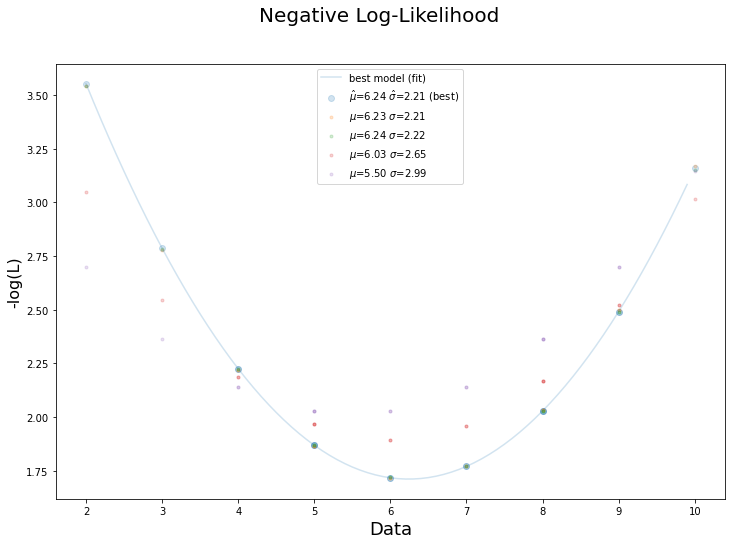

In [28]:
#plot N top
Ntop = 3
fig, ax = plt.subplots(figsize = (12,8))
fig.suptitle('Negative Log-Likelihood', fontsize=20)
plt.xlabel('Data', fontsize=18)
plt.ylabel('-log(L)', fontsize=16)


best_color = ''
for i, p in enumerate(nllh_results[:Ntop]):
    path_collection = ax.scatter(X_data,
                                 p.nllh,
                                 alpha=p.alpha,
                                 label=p.label,
                                 marker='.' if i else 'o')
    if not i:
        best_color = path_collection.get_facecolor()[0]

#best_color = plt.gca().lines[0].get_color()

#plot also  middle and last
middle_idx=int(len(nllh_results)/2)

ax.scatter(X_data,
           nllh_results[middle_idx].nllh,
           alpha=nllh_results[middle_idx].alpha,
           label=nllh_results[middle_idx].label,
           marker='.')
ax.scatter(X_data,
           nllh_results[-1].nllh,
           alpha=nllh_results[-1].alpha,
           label=nllh_results[-1].label,
           marker='.')

#draw line for the best model
from scipy.optimize import curve_fit

# define the true objective function
def parabola(x, a, b, c):
    #intentionally set b=0
    #b=0
    return a + b*x + c*x**2

# curve fit
popt, _ = curve_fit(parabola, X_data, nllh_results[0].nllh)

# summarize the parameter values
a, b, c = popt

# define a sequence of inputs between the smallest and largest known inputs
dx = 0.1
x_line = np.arange(min(X_data), max(X_data), dx)

# calculate the output for the range
y_line = parabola(x_line, a, b, c)

# create a line plot for the mapping function
plt.plot(x_line, y_line, '-', color=best_color, label='best model (fit)')


ax.legend(loc="upper center")

Each of the scattered data set represents a different likelihood function for different values of $\mu$ and $\sigma$ and is centered roughly around the the same minimum. The best estimate corresponds to the case with $\hat{\mu}=6.24$ and $\hat{\sigma}=2.21$ and is illustrated by the big markers connected with a parabola. So, our data are more likely to originate from a normal distribution with those parameter values.

With that said, we can now plot our input data and overlay our PDF function to intuitively view how it fits them.

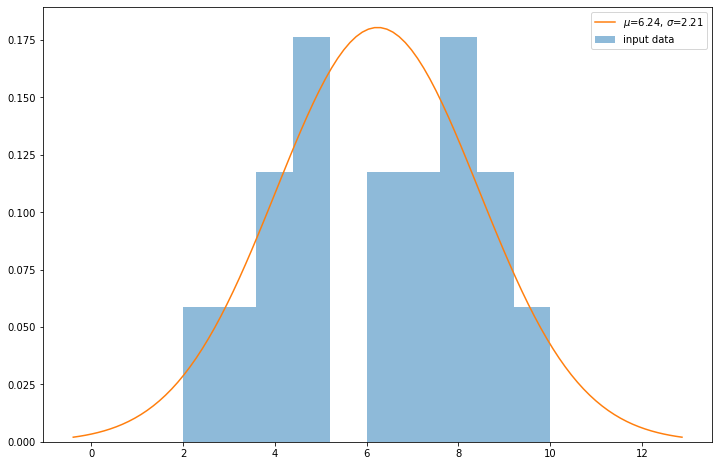

In [31]:
def xs(μ, σ):
    return np.linspace(μ - 3*σ, μ + 3*σ, 100)

def gauss(μ, σ):
    x = xs(μ, σ)
    plt.plot(x, stats.norm.pdf(x, μ, σ), label=f'$\mu$={μ:.2f}, $\sigma$={σ:.2f}')


# plot best with data
fig, ax = plt.subplots(figsize = (12,8))
X_weights = np.ones_like(X_data) / len(X_data)
ax.hist(X_data, weights=X_weights, label='input data', alpha=0.5)
gauss(nllh_results[0].μ, nllh_results[0].σ)

ax.legend(loc="upper right")

## Synopsis

Maximum likelihood estimation (MLE) is an elegant estimation method that allows to use a sample to estimate the parameters of the probability distribution that generated the sample.

A maximum likelihood estimator $\widehat{\theta}$ of $\theta_{0}$ is obtained as a solution of a maximization problem:

\begin{equation}
\widehat{\theta} = \underset{\theta\; \in\; \Theta}{\arg \max} \cal{L}(x;\,\theta)
\end{equation}

where $\Theta$ is a set of of real vectors (called the parameter space) whose elements (called parameters) are put into correspondence with the possible distributions of $x_i$.
 
In other words, $\widehat{\theta}$ is the parameter that maximizes the likelihood of the sample $x_i$. 
$\widehat{\theta}$ is called the maximum likelihood estimator of $\theta$.

The  estimator can be obtained as a solution of the above equation, i.e. by maximizing the logarithm of the likelihood function, the log-likelihood. Solving this problem is equivalent to solving the original one, because the logarithm is a strictly increasing function.

In some cases, the maximum likelihood problem has an analytical solution. 
That is, it is possible to write the maximum likelihood estimator $\widehat{\theta}$ explicitly as a function of the data. 
However, in many cases there is no explicit solution. 
In these cases, numerical optimization algorithms are used to maximize the log-likelihood, 
or minimize the negative log-likelihood. 